## Universal Approximation Theorem: Foundation of Neural Networks
The Universal Approximation Theorem establishes that neural networks, even with just a single hidden layer, can approximate virtually any continuous function to arbitrary precision, providing the mathematical foundation for their remarkable effectiveness as universal function approximators. However, in practice, we implement deeper architectures with multiple layers of decreasing width (often following powers of 2) to achieve comparable approximation capabilities with significantly fewer total parameters, making them computationally efficient for modern hardware.

[Resource: Universal Approximation Theorem](https://www.youtube.com/watch?v=eeq2aG9TKY8&t=4023s)

[Recommended YouTube Chaneel For Linear Algebra:](https://www.youtube.com/@3blue1brown)

# Visualizing Nonlinear Activations

(this image is missing translation, which is adding a bias)

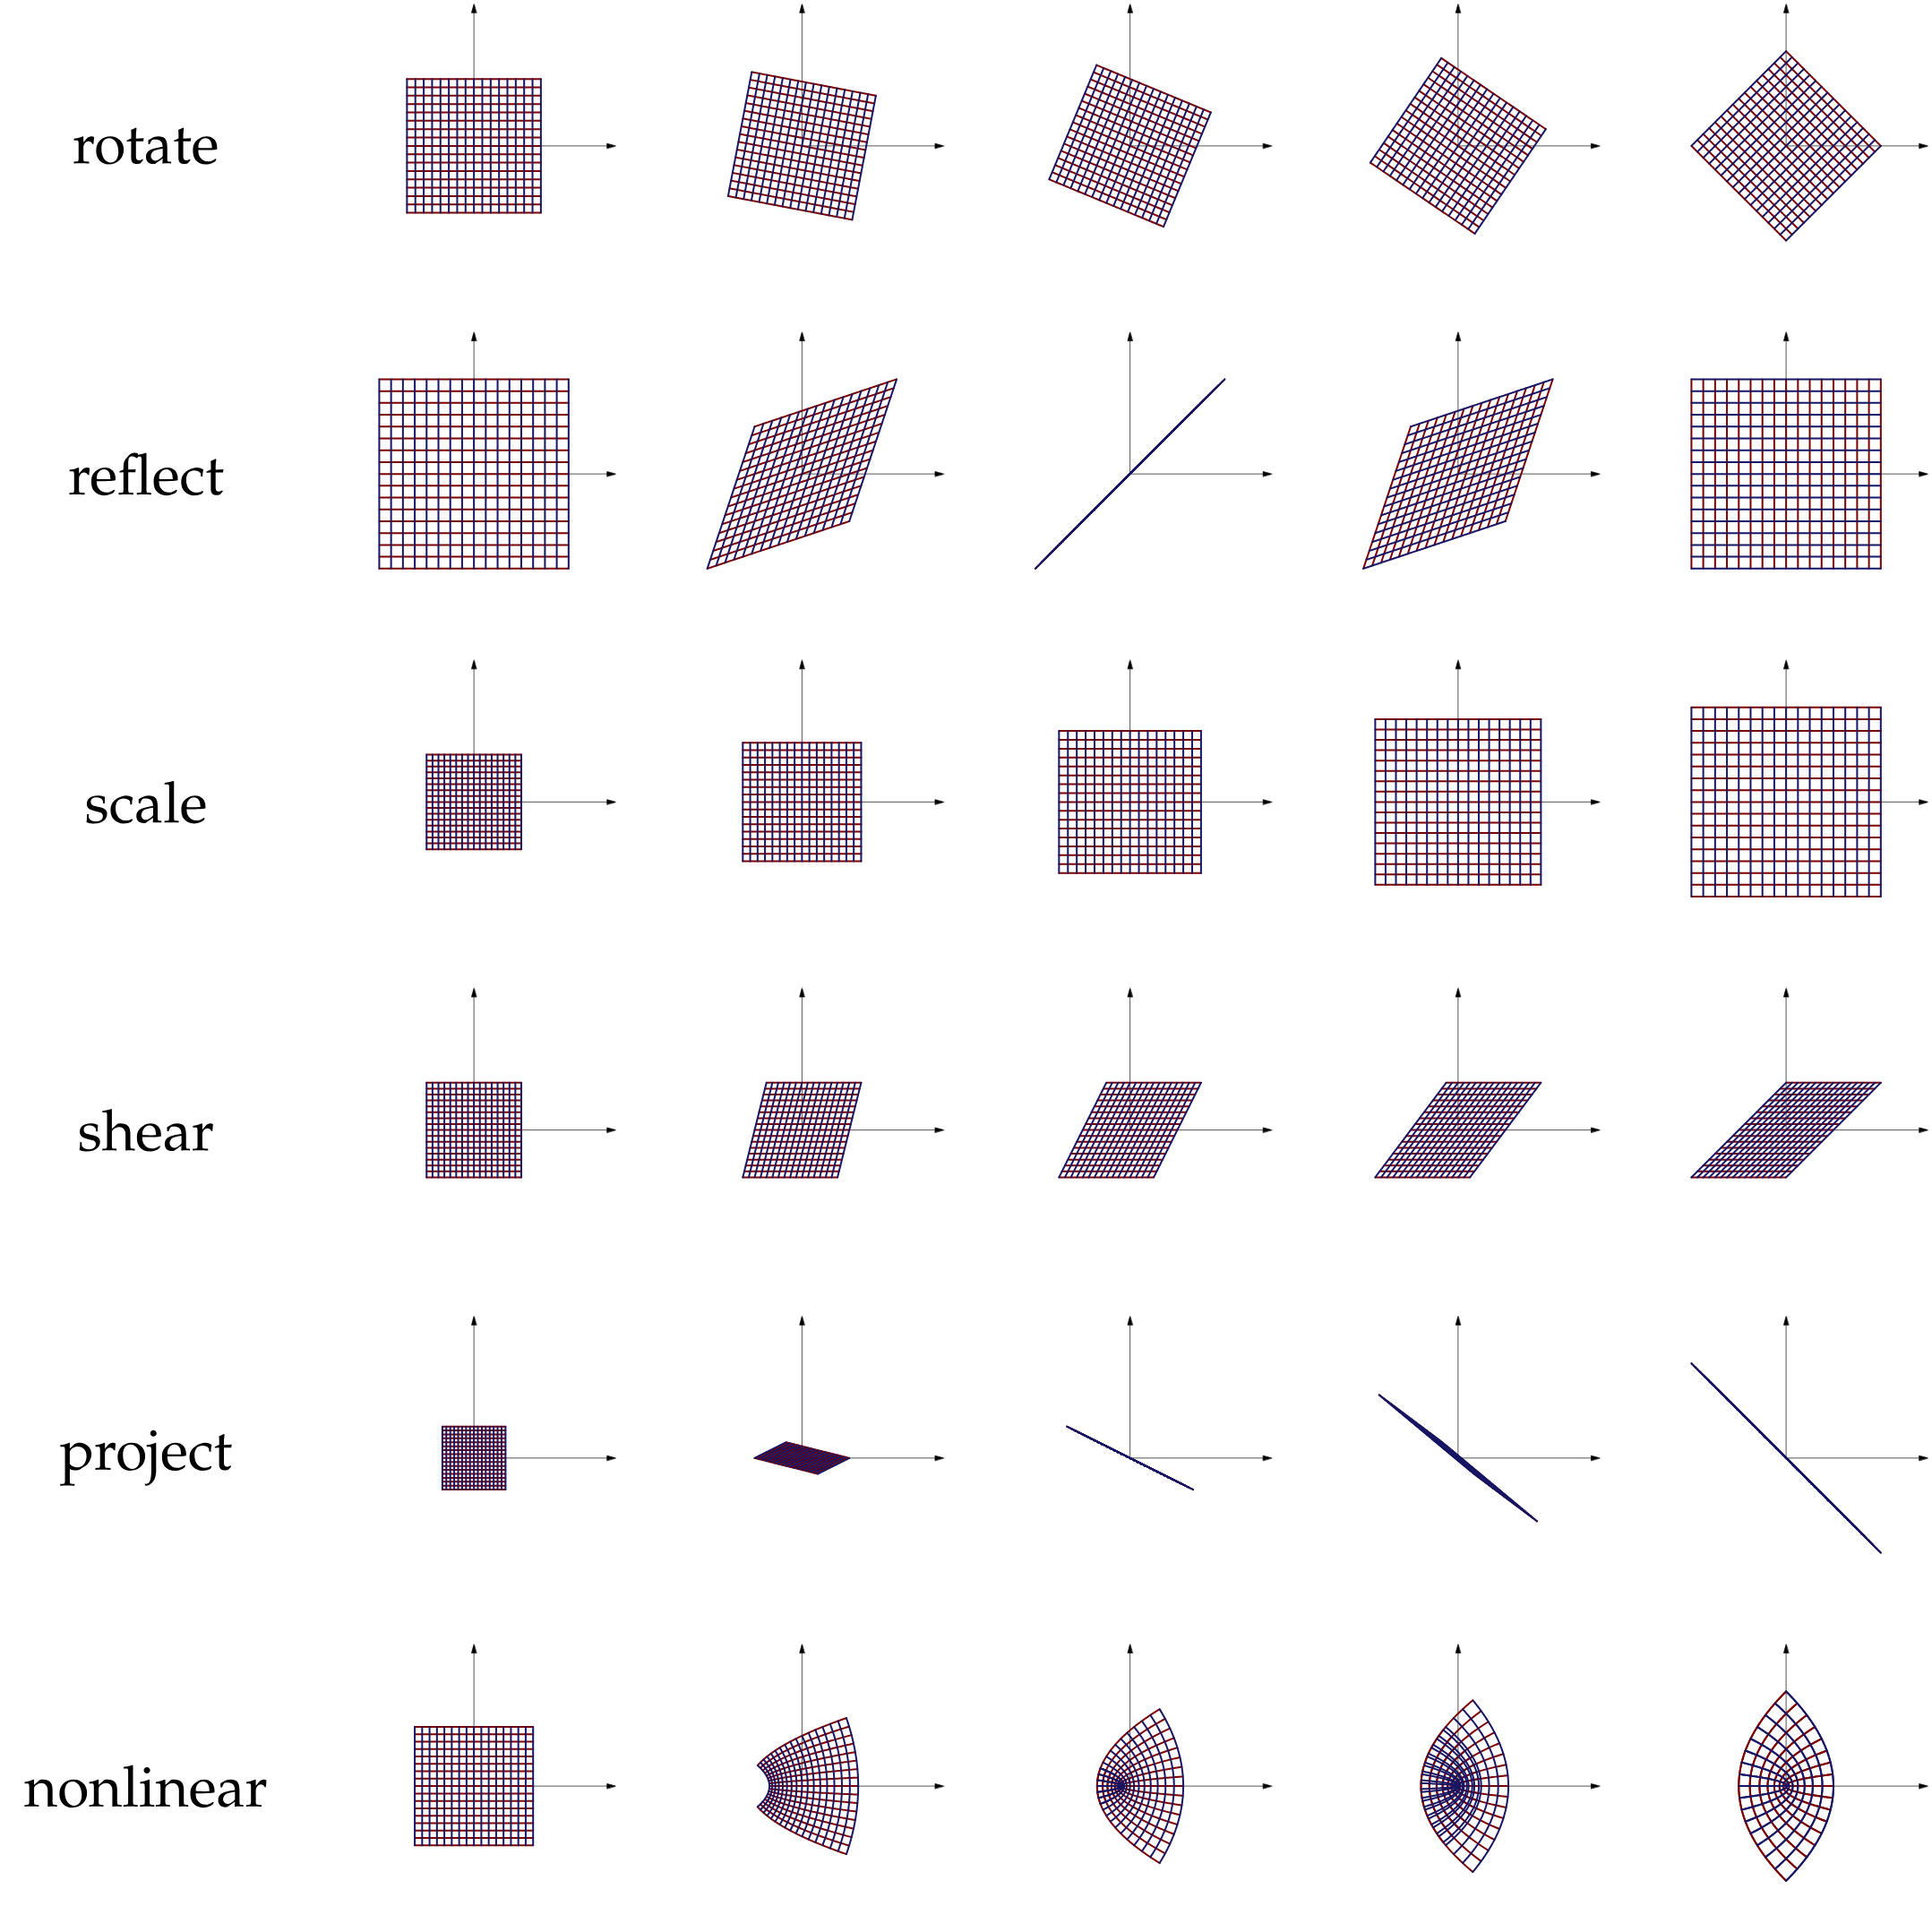

[image credit](https://mathigon.org/course/linear-algebra/linear-transformations)

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np # Used for isclose in example, though torch.isclose is used in function

## Before and After

Here is a function that will visualize a grid of 2D vectors both before and after applying an activation function.

In [ ]:
def plot_activation_grid(min_val: float,
                         max_val: float,
                         step_size: float,
                         activation_function_pytorch: torch.nn.Module):
    """
    Creates two side-by-side scatter plots to visualize the effect of a PyTorch activation function
    on a 2D grid of points.

    The grid consists of points (x, y) where x and y range from min_val to max_val
    with the given step_size. Points are colored based on their original coordinates.
    The left plot shows the original grid. The right plot shows the grid after
    applying the activation function to each coordinate. The right plot uses the same
    axis range as the left plot for direct comparison.

    Args:
        min_val (float): The minimum value for the x and y coordinates of the grid.
        max_val (float): The maximum value for the x and y coordinates of the grid.
        step_size (float): The step size for generating the grid of numbers.
        activation_function_pytorch (torch.nn.Module): A PyTorch activation function module
                                                       (e.g., torch.nn.ReLU(), torch.nn.Sigmoid(),
                                                       torch.nn.Tanh()).
    """
    # Input validation
    if not all(isinstance(val, (float, int)) for val in [min_val, max_val, step_size]):
        raise ValueError("min_val, max_val, and step_size must be numbers.")
    if min_val >= max_val:
        raise ValueError("min_val must be less than max_val.")
    if step_size <= 0:
        raise ValueError("step_size must be a positive number.")
    if not isinstance(activation_function_pytorch, torch.nn.Module):
        raise TypeError("activation_function_pytorch must be a torch.nn.Module instance.")

    # 1. Generate the 1D coordinates for the grid
    # Convert to float for torch.arange and subsequent calculations
    f_min_val = float(min_val)
    f_max_val = float(max_val)

    # torch.arange(start, end, step) creates values in [start, end).
    # To include 'end' (f_max_val in this case) if it's a multiple of step_size from f_min_val,
    # we extend the range slightly beyond f_max_val for arange.
    axis_coords = torch.arange(f_min_val, f_max_val + step_size / 2.0, step_size, dtype=torch.float32)

    # Ensure coordinates are strictly within [f_min_val, f_max_val] after generation
    axis_coords = axis_coords[axis_coords <= f_max_val + 1e-6] # Allow tiny tolerance for f_max_val
    axis_coords = axis_coords[axis_coords >= f_min_val - 1e-6] # Allow tiny tolerance for f_min_val

    # Snap to exact f_min_val and f_max_val if very close
    if len(axis_coords) > 0:
        if torch.isclose(axis_coords[0], torch.tensor(f_min_val)):
            axis_coords[0] = f_min_val
        if torch.isclose(axis_coords[-1], torch.tensor(f_max_val)):
            axis_coords[-1] = f_max_val

    x_coords = axis_coords
    y_coords = axis_coords

    if len(x_coords) == 0 or len(y_coords) == 0:
        print(f"Warning: With step_size {step_size} for range [{f_min_val}, {f_max_val}], no grid points were generated.")
        return

    # Create the 2D grid using meshgrid
    grid_x, grid_y = torch.meshgrid(x_coords, y_coords, indexing='ij')

    original_points_x = grid_x.flatten()
    original_points_y = grid_y.flatten()

    original_points = torch.stack((original_points_x, original_points_y), dim=1)

    # 2. Generate colors based on original coordinates
    # Normalize coordinates from [f_min_val, f_max_val] to [0, 1] for RGB channels
    data_range = f_max_val - f_min_val
    if data_range == 0: # Should not happen due to min_val < max_val check, but for safety
        colors_r = torch.full_like(original_points_x, 0.5)
        colors_g = torch.full_like(original_points_y, 0.5)
    else:
        colors_r = (original_points_x - f_min_val) / data_range
        colors_g = (original_points_y - f_min_val) / data_range

    colors_b = torch.full_like(colors_r, 0.3) # Constant blue channel for distinctiveness

    point_colors = torch.stack((
        torch.clamp(colors_r, 0, 1),
        torch.clamp(colors_g, 0, 1),
        torch.clamp(colors_b, 0, 1)
    ), dim=1).numpy()


    # 3. Apply the activation function
    activation_function_pytorch.eval()
    with torch.no_grad():
        transformed_points = activation_function_pytorch(original_points)

    # 4. Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Define axis limits based on input range with some padding
    padding_factor = 0.1  # 10% padding
    plot_range = f_max_val - f_min_val
    padding = plot_range * padding_factor

    # Handle case where plot_range is very small or zero to avoid excessive padding
    if plot_range < 1e-6 : # Effectively if min_val is very close to max_val
        padding = 0.1 # Default small padding

    axis_lim_min = f_min_val - padding
    axis_lim_max = f_max_val + padding

    # Ensure limits are symmetrical if min_val = -max_val for aesthetic purposes
    if np.isclose(f_min_val, -f_max_val):
        abs_max_coord = max(abs(f_min_val), abs(f_max_val))
        sym_padding = abs_max_coord * padding_factor
        if plot_range < 1e-6: sym_padding = 0.1
        axis_lim_min = -abs_max_coord - sym_padding
        axis_lim_max = abs_max_coord + sym_padding


    # Left Plot: Original Grid
    axes[0].scatter(original_points[:, 0].numpy(), original_points[:, 1].numpy(),
                    c=point_colors, s=35, edgecolor='k', linewidth=0.3, alpha=0.85)
    axes[0].set_title('Original Grid', fontsize=14)
    axes[0].set_xlabel('x', fontsize=12)
    axes[0].set_ylabel('y', fontsize=12)
    axes[0].set_xlim(axis_lim_min, axis_lim_max)
    axes[0].set_ylim(axis_lim_min, axis_lim_max) # Use same limits for x and y for square aspect
    axes[0].axhline(0, color='black', lw=0.75, linestyle='--')
    axes[0].axvline(0, color='black', lw=0.75, linestyle='--')
    axes[0].grid(True, linestyle=':', alpha=0.6)
    axes[0].set_aspect('equal', adjustable='box')

    # Right Plot: Transformed Grid
    axes[1].scatter(transformed_points[:, 0].numpy(), transformed_points[:, 1].numpy(),
                    c=point_colors, s=35, edgecolor='k', linewidth=0.3, alpha=0.85)
    axes[1].set_title(f'Grid after {activation_function_pytorch.__class__.__name__}', fontsize=14)
    axes[1].set_xlabel('Transformed x', fontsize=12)
    axes[1].set_ylabel('Transformed y', fontsize=12)

    # Use the same axis limits as the left plot
    axes[1].set_xlim(axis_lim_min, axis_lim_max)
    axes[1].set_ylim(axis_lim_min, axis_lim_max)

    axes[1].axhline(0, color='black', lw=0.75, linestyle='--')
    axes[1].axvline(0, color='black', lw=0.75, linestyle='--')
    axes[1].grid(True, linestyle=':', alpha=0.6)
    axes[1].set_aspect('equal', adjustable='box')

    plt.suptitle(f'Grid Transformation by {activation_function_pytorch.__class__.__name__}\nInput Range: [{f_min_val:.2f}, {f_max_val:.2f}], Step: {step_size}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust layout for suptitle
    plt.show()

## [ReLU](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

In [ ]:
x = torch.arange(-5.0, 5.0, 0.05)

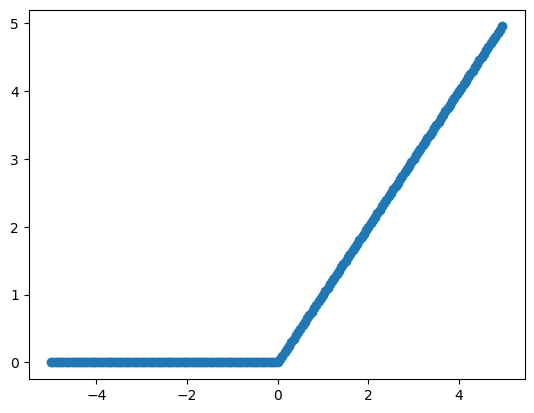

In [ ]:
y = torch.nn.ReLU()(x)
plt.scatter(x.numpy(), y.numpy())

Plotting with ReLU activation, range [-2, 2]...


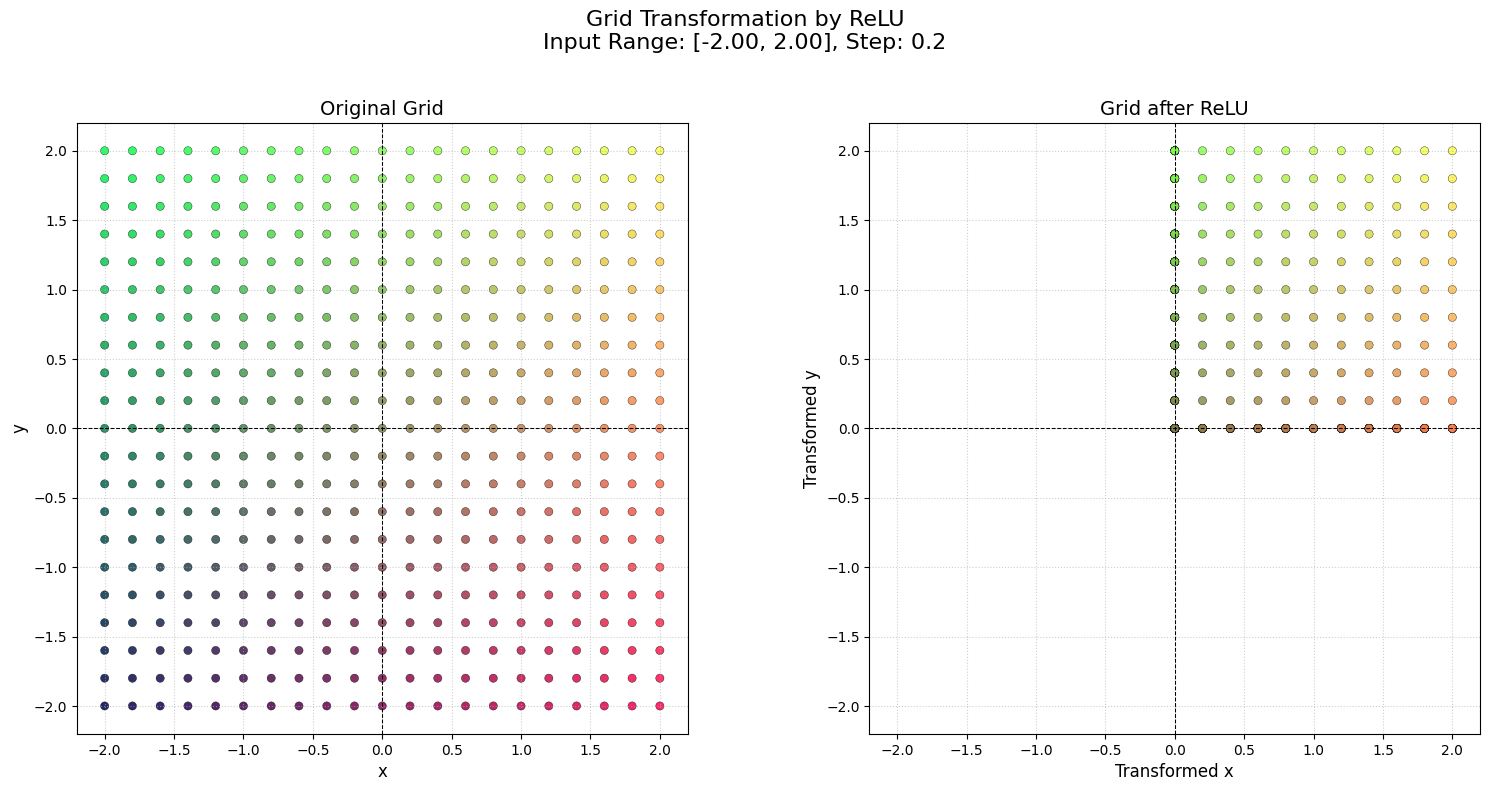

In [ ]:
print("Plotting with ReLU activation, range [-2, 2]...")
relu_activation = torch.nn.ReLU()
plot_activation_grid(min_val=-2.0, max_val=2.0, step_size=0.2, activation_function_pytorch=relu_activation)

## [LeakyReLU](https://docs.pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU)

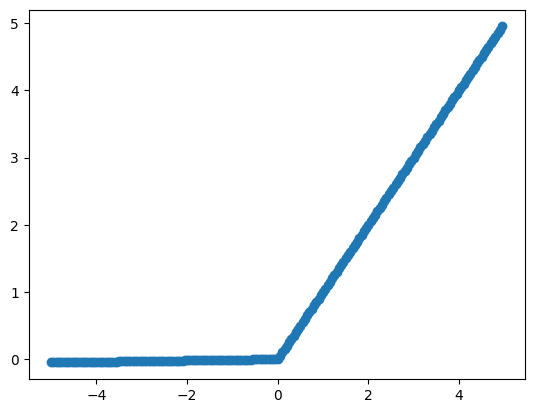

In [ ]:
y = torch.nn.LeakyReLU()(x)
plt.scatter(x.numpy(), y.numpy())

Plotting with LeakyReLU activation, range [-1.5, 1.5], negative_slope=0.1...


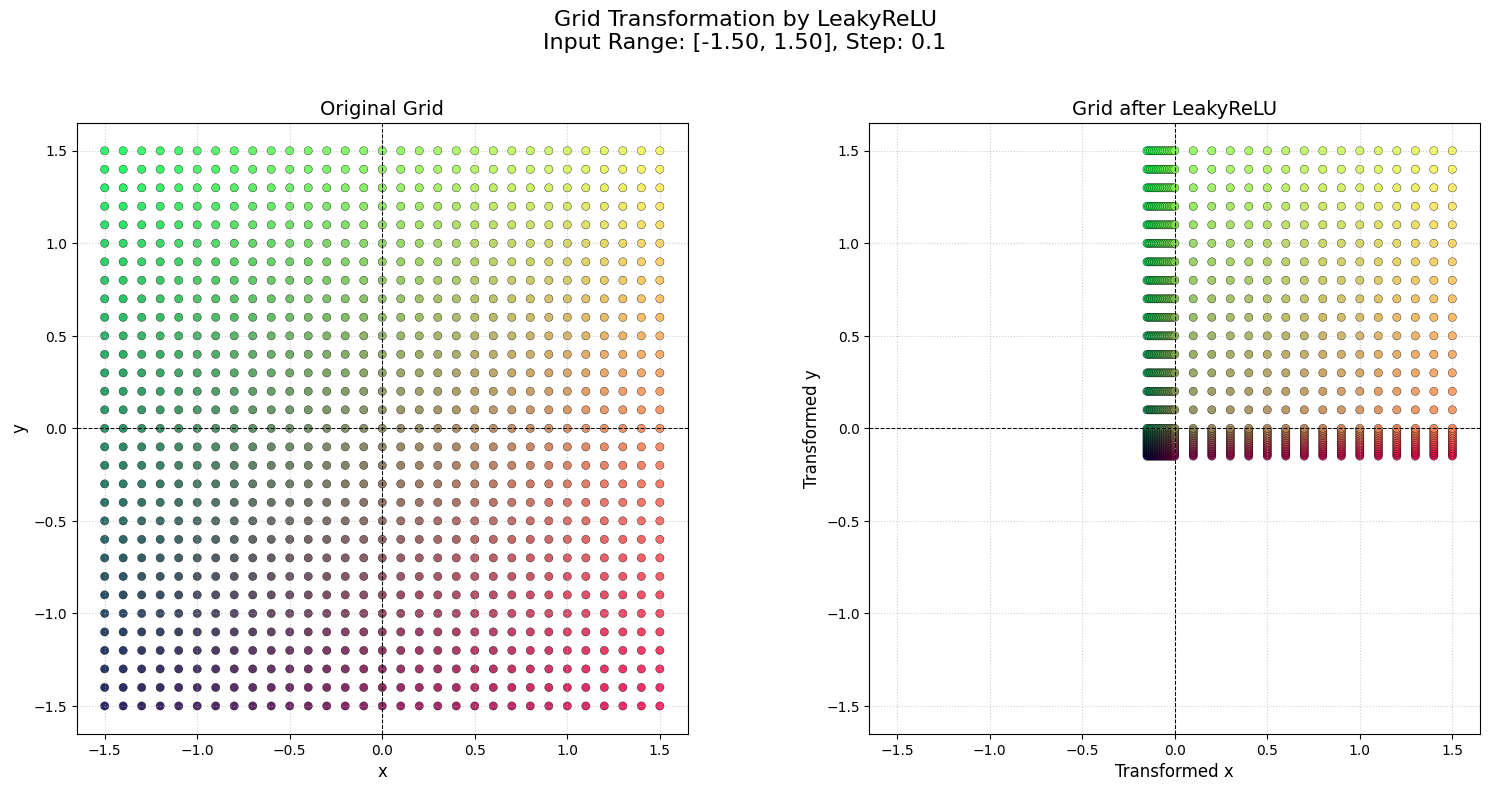

In [ ]:
print("Plotting with LeakyReLU activation, range [-1.5, 1.5], negative_slope=0.1...")
leaky_relu_activation = torch.nn.LeakyReLU(negative_slope=0.1) # Changed slope for variety
plot_activation_grid(min_val=-1.5, max_val=1.5, step_size=0.1, activation_function_pytorch=leaky_relu_activation)

## [Sigmoid](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid)

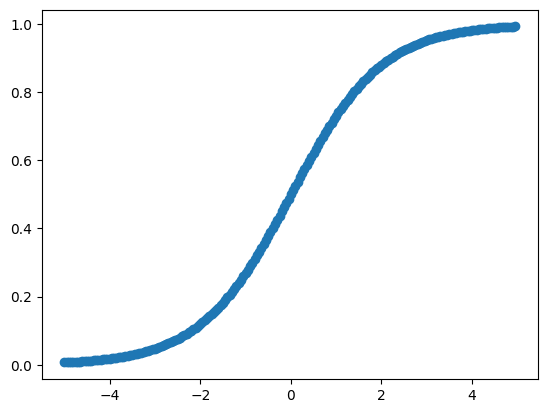

In [ ]:
y = torch.nn.Sigmoid()(x)
plt.scatter(x.numpy(), y.numpy())

Plotting with Sigmoid activation, range [-5, 5]...


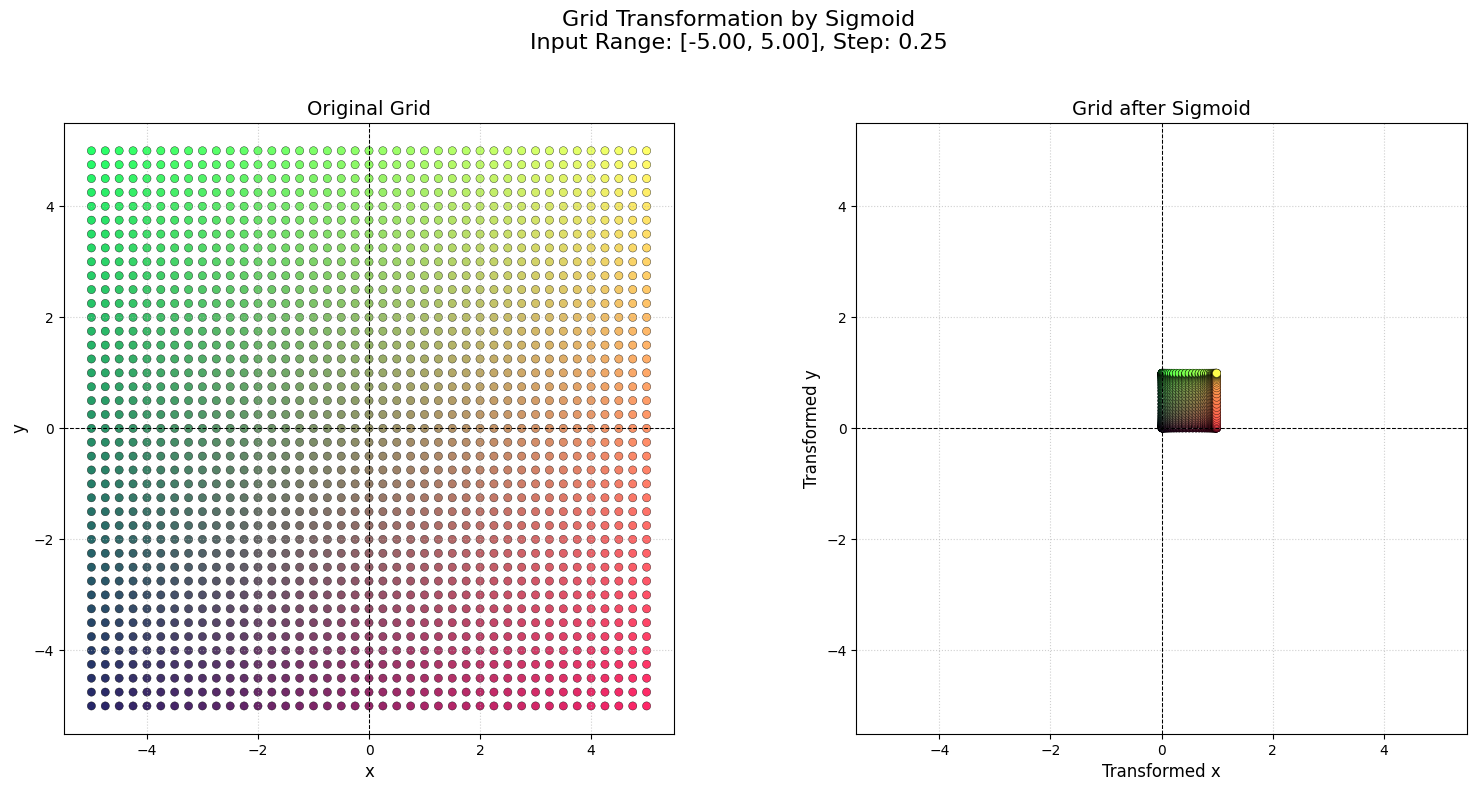

In [ ]:
print("Plotting with Sigmoid activation, range [-5, 5]...")
sigmoid_activation = torch.nn.Sigmoid()
plot_activation_grid(min_val=-5.0, max_val=5.0, step_size=0.25, activation_function_pytorch=sigmoid_activation)

## [Tanh](https://docs.pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

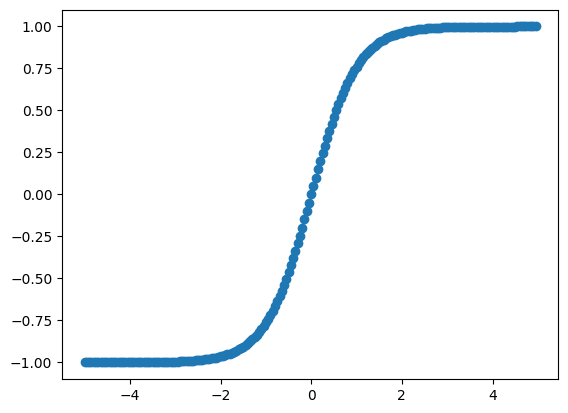

In [ ]:
y = torch.nn.Tanh()(x)
plt.scatter(x.numpy(), y.numpy())

Plotting with Tanh activation, range [-3, 3]...


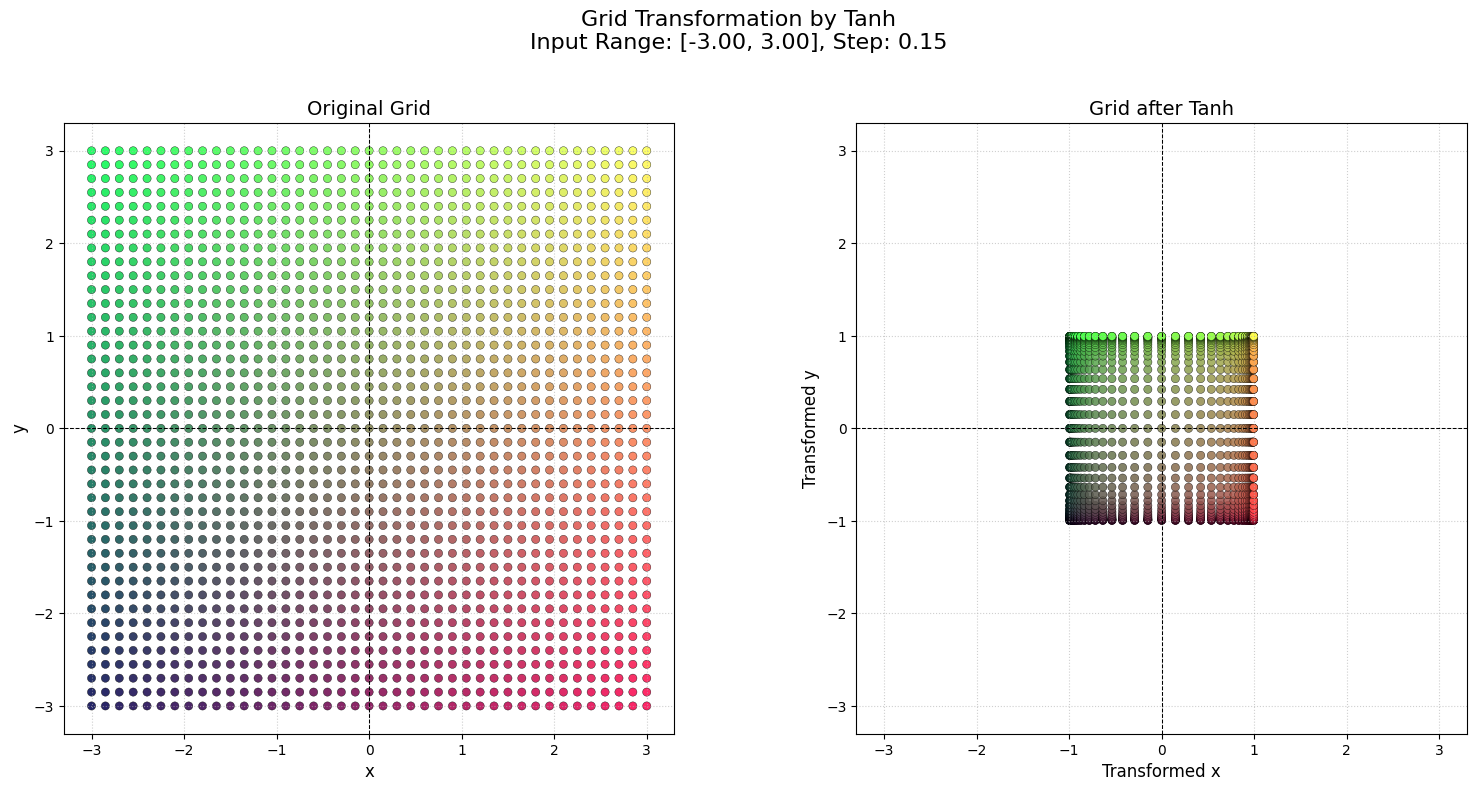

In [ ]:
print("Plotting with Tanh activation, range [-3, 3]...")
tanh_activation = torch.nn.Tanh()
plot_activation_grid(min_val=-3.0, max_val=3.0, step_size=0.15, activation_function_pytorch=tanh_activation)

## Swish

In [ ]:
# Example with a custom nn.Module activation
class Swish(torch.nn.Module):
    def __init__(self, beta_val=1.0): # Allow beta to be passed
        super().__init__()
        # Make beta a buffer if it's not meant to be trained, or Parameter if it is
        self.register_buffer('beta', torch.tensor(beta_val))
        # If beta should be learnable:
        # self.beta = torch.nn.Parameter(torch.tensor(beta_val))


    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)

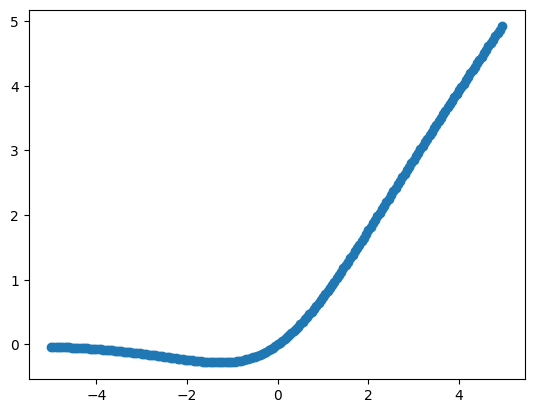

In [ ]:
y = Swish()(x)
plt.scatter(x.numpy(), y.numpy())

Plotting with Swish (beta=1.5) activation, range [-4, 4]...


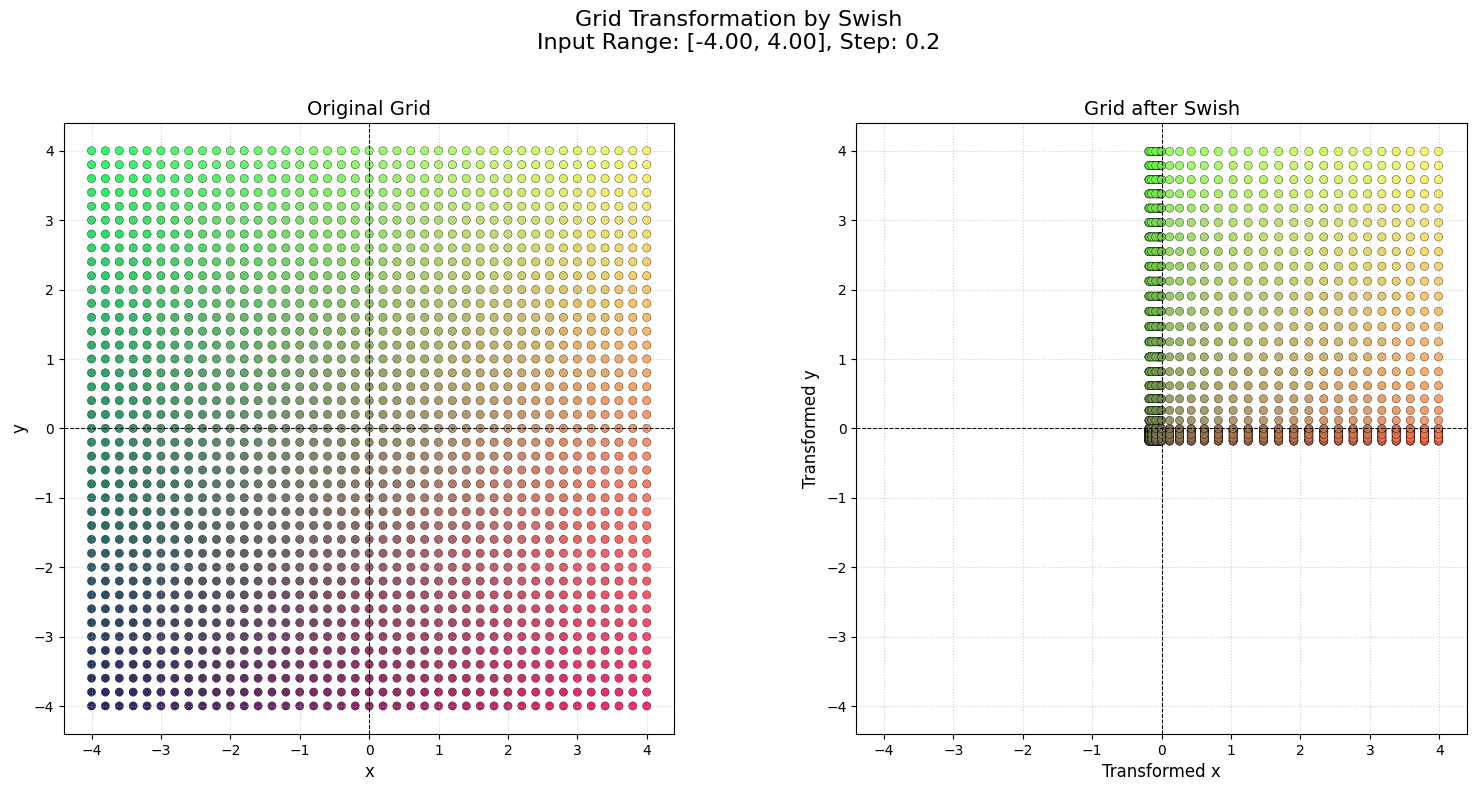

In [ ]:
print("Plotting with Swish (beta=1.5) activation, range [-4, 4]...")
swish_activation_1_5 = Swish(beta_val=1.5)
plot_activation_grid(min_val=-4.0, max_val=4.0, step_size=0.2, activation_function_pytorch=swish_activation_1_5)

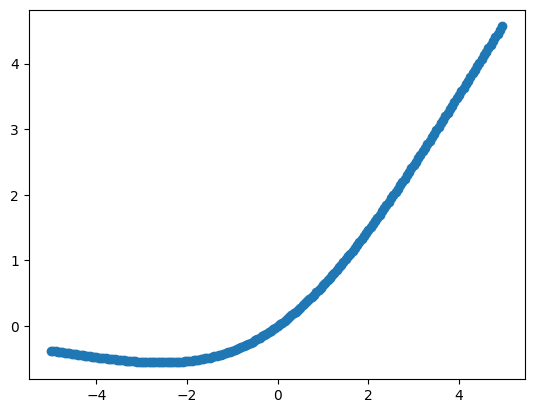

In [ ]:
y = Swish(beta_val=0.5)(x)
plt.scatter(x.numpy(), y.numpy())

Plotting with Swish (beta=0.5) activation, range [-4, 4]...


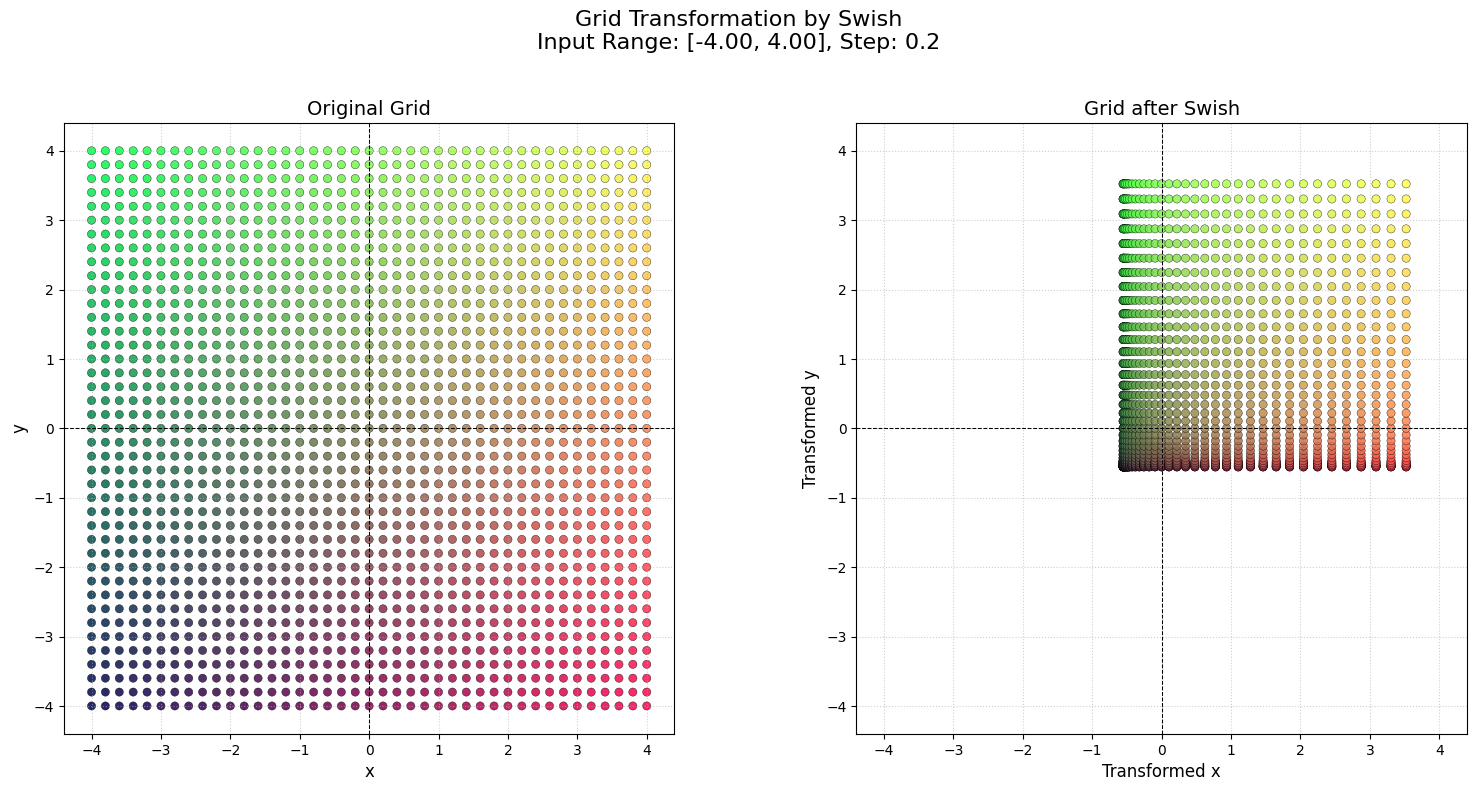

In [ ]:
print("Plotting with Swish (beta=0.5) activation, range [-4, 4]...")
swish_activation_0_5 = Swish(beta_val=0.5)
plot_activation_grid(min_val=-4.0, max_val=4.0, step_size=0.2, activation_function_pytorch=swish_activation_0_5)

# A Simple Non-linear Problem

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim

    self.fc = nn.Sequential(
        nn.Linear(self.input_dim, self.hidden_dim),
        nn.ReLU(),
        nn.Linear(self.hidden_dim, self.output_dim)
    )

  def forward(self, x):
    # the `Sequential` can just be called on the input
    return self.fc(x)

In [ ]:
'''
a `Dataset` is an interface for defining data to train on. it requires defining
* __init__
* __len__ to return the number of training examples
* __getitem__ to return an example at a specific index
'''
from torch.utils.data import Dataset

class XorDataset(Dataset):
  def __init__(self):
    # example inputs
    self.x = [
        [0, 0],
        [1, 0],
        [0, 1],
        [1, 1]
    ]
    # example outputs
    self.y = [
        [0],
        [1],
        [1],
        [0]
    ]

  def __len__(self):
    # return the number of training examples
    return len(self.x)

  def __getitem__(self, idx):
    # return the input/output for a given example (by index)
    x = self.x[idx]
    y = self.y[idx]
    return {'x': torch.FloatTensor(x), 'y': torch.FloatTensor(y)}

xor_dataset = XorDataset()
print(xor_dataset[2])

{'x': tensor([0., 1.]), 'y': tensor([1.])}


In [ ]:
from torch.utils.data import DataLoader

batch_size = 4

dataloader = DataLoader(xor_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for batch in dataloader:
  x = batch['x']
  y = batch['y']
  print(x, 'x.size()', x.size())
  print(y, 'y.size()', y.size())

tensor([[1., 0.],
        [0., 1.],
        [1., 1.],
        [0., 0.]]) x.size() torch.Size([4, 2])
tensor([[1.],
        [1.],
        [0.],
        [0.]]) y.size() torch.Size([4, 1])


In [ ]:
device = 'cpu'

In [ ]:
from torch.optim import Adam
from tqdm import trange  # gives us a nice progress bar

epochs = 5000  # the number of times to iterate through the training data

model = MLP(2, 2, 1)  # create an instance of our model
model = model.to(device)  # send the model to the appropriate device
print(model.train())  # set the model to train mode (default) and print it for good measure
opt = Adam(model.parameters(), lr=0.001)  # initialize the optimizer with the model parameters
loss_fn = nn.MSELoss()  # create an instance of our loss function
losses = []  # create an empty list for tracking the loss every epoch

for epoch in trange(epochs):  # loop for the number of epochs
  for batch in dataloader:  # iterate through the dataset

    # get the inputs and target outputs and send them to the device
    x = batch['x'].to(device)
    y = batch['y'].to(device)

    # run the model and get its prediction
    y_hat = model(x)

    # calculate the loss
    loss = loss_fn(y_hat, y)

    # clear the previous gradient from the optimizer
    opt.zero_grad()
    # calculate the gradient based on the loss
    loss.backward()
    # update the model weights based on the gradient
    opt.step()

    '''
    Store the loss in a list so that we can plot it later.
    When doing so however, we need to call `.detach()` in
    order to remove the gradient, `.cpu()` to make sure it
    is on the CPU, and `.numpy()` to convert it into a numpy
    value because matplotlib doesn't work directly on tensors.
    '''
    losses.append(loss.detach().cpu().numpy())

MLP(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
)


100%|██████████| 5000/5000 [00:06<00:00, 735.84it/s]


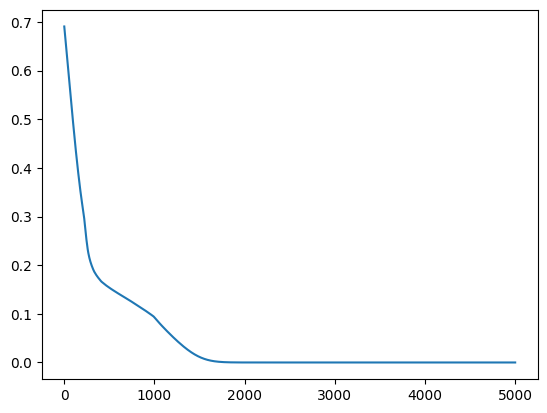

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [ ]:
model = model.cpu()
model.eval()

with torch.no_grad():
  for example in xor_dataset:
    x = example['x']
    y = example['y']
    y_hat = model(x)
    loss = loss_fn(y_hat, y)
    print('x:', x, 'y:', y, 'y_hat:', y_hat, 'loss:', loss)

x: tensor([0., 0.]) y: tensor([0.]) y_hat: tensor([7.5996e-07]) loss: tensor(5.7754e-13)
x: tensor([1., 0.]) y: tensor([1.]) y_hat: tensor([1.0000]) loss: tensor(3.5527e-13)
x: tensor([0., 1.]) y: tensor([1.]) y_hat: tensor([1.0000]) loss: tensor(3.5527e-13)
x: tensor([1., 1.]) y: tensor([0.]) y_hat: tensor([-1.1921e-07]) loss: tensor(1.4211e-14)


## Layer by Layer

In [ ]:
x = xor_dataset[0]['x'].unsqueeze(0)
x

tensor([[0., 0.]])

In [ ]:
model

MLP(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
)

### Linear 1

In [ ]:
model.fc[0].bias

Parameter containing:
tensor([3.6777e-09, 1.0973e-01], requires_grad=True)

In [ ]:
model.fc[0].weight

Parameter containing:
tensor([[ 1.4590, -1.3674],
        [-0.8324,  0.7767]], requires_grad=True)

In [ ]:
x1 = x @ model.fc[0].weight
x1

tensor([[0., 0.]], grad_fn=<MmBackward0>)

### Activation

In [ ]:
x2 = model.fc[1](x1)
x2

tensor([[0., 0.]], grad_fn=<ReluBackward0>)

### Linear 2

In [ ]:
model.fc[2].weight

Parameter containing:
tensor([[0.7822, 1.2875]], requires_grad=True)

In [ ]:
model.fc[2].bias

Parameter containing:
tensor([-0.1413], requires_grad=True)

In [ ]:
x3 = model.fc[2](x2)
x3

tensor([[7.5996e-07]], grad_fn=<AddmmBackward0>)

In [ ]:
x3 = x2 @ model.fc[2].weight.t()
x3

tensor([[0.]], grad_fn=<MmBackward0>)

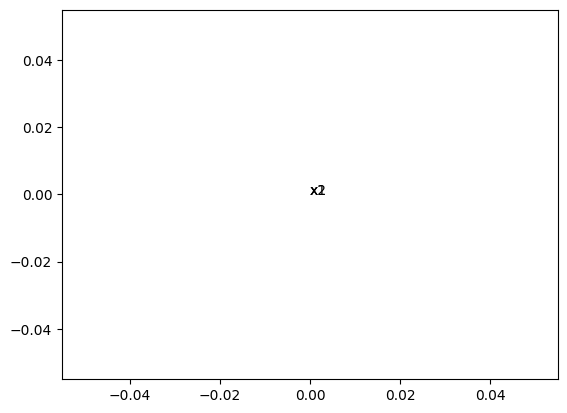

In [ ]:
points = torch.concat([x, x1, x2], dim=0).detach()
xs = points[:, 0].numpy()
ys = points[:, 1].numpy()
plt.plot(xs, ys)
labels = ['x', 'x1', 'x2']
for i, label in enumerate(labels):
    plt.annotate(label, (xs[i], ys[i]))

Here is the `xor` function written in terms of input components

In [ ]:
def manual_xor(x, y):
  return max(0, x-y) + max(0, y-x)

In [ ]:
for example in xor_dataset:
  x = example['x']
  y = example['y']
  print(x, y, manual_xor(x[0].tolist(), x[1].tolist()))

tensor([0., 0.]) tensor([0.]) 0
tensor([1., 0.]) tensor([1.]) 1.0
tensor([0., 1.]) tensor([1.]) 1.0
tensor([1., 1.]) tensor([0.]) 0


Here is the same thing written with matricies

In [ ]:
def matrix_xor(vector):
  layer1 = torch.FloatTensor([[1, -1],
                              [-1, 1]])  # transformation
  layer2 = torch.FloatTensor([[1, 1]])  # linear clasifier
  return (vector @ layer1).relu() @ layer2.t()

In [ ]:
for example in xor_dataset:
  x = example['x']
  y = example['y']
  print(x, y, matrix_xor(x.unsqueeze(0)))

tensor([0., 0.]) tensor([0.]) tensor([[0.]])
tensor([1., 0.]) tensor([1.]) tensor([[1.]])
tensor([0., 1.]) tensor([1.]) tensor([[1.]])
tensor([1., 1.]) tensor([0.]) tensor([[0.]])


See how the weights of our neural network end up being more or less what we wrote by hand?

[Here's](https://towardsdatascience.com/a-fresh-look-at-nonlinearity-in-deep-learning-a79b6955d2ad/) an article going through this same problem. Below is a visualization of what we sould see if we plotted the output of `ReLU` in our neural network.

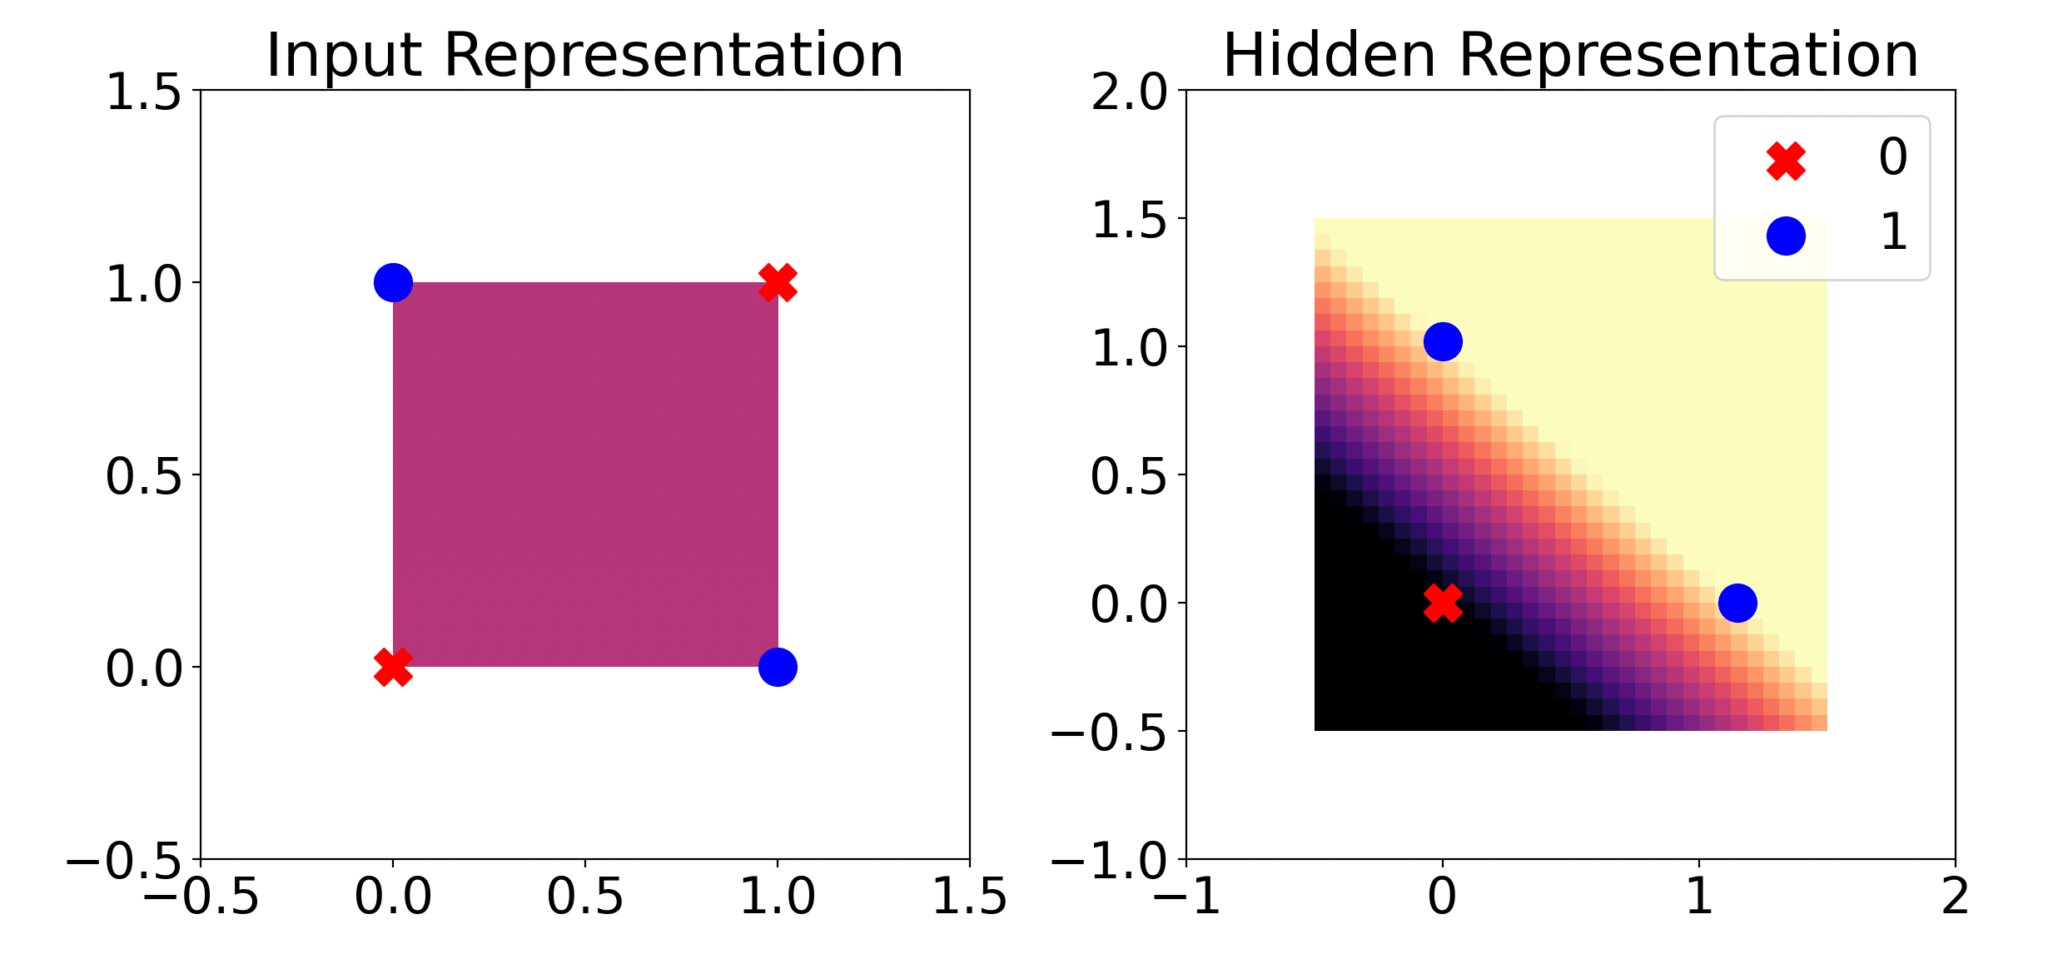